In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from prophet import Prophet
from xgboost import XGBRegressor

In [3]:
# Load dataset
data = pd.read_csv('dataset.csv')

In [4]:
# Inspect data
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB
None
         date      demand        RRP  demand_pos_RRP  RRP_positive  \
0  2015-01-01   99635.030  

In [5]:
# Preserve 'date' column for Prophet
if 'date' in data.columns:
    date_column = data['date']

In [6]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
data[data.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(data.select_dtypes(include=[np.number]))

In [7]:
# Handle outliers using IQR
for col in data.select_dtypes(include=[np.number]).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

In [8]:
# Convert categorical to binary
if 'school_day' in data.columns and 'holiday' in data.columns:
    data['is_school_day'] = data['school_day'].apply(lambda x: 1 if x == 'Y' else 0)
    data['is_holiday'] = data['holiday'].apply(lambda x: 1 if x == 'Y' else 0)
    data.drop(columns=['school_day', 'holiday'], inplace=True)

In [9]:
# Encode categorical variables
cat_features = data.select_dtypes(include=['object']).columns.tolist()
if 'date' in cat_features:
    cat_features.remove('date')

if cat_features:
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(data[cat_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_features))
    data = pd.concat([data, encoded_df], axis=1)
    data.drop(columns=cat_features, inplace=True)

In [10]:
# Restore 'date' column
data['date'] = date_column

In [11]:
# Calculate average temperature
data['temperature'] = (data['min_temperature'] + data['max_temperature']) / 2

In [12]:
# Save cleaned data
data.to_csv('cleaned_dataset.csv', index=False)

In [13]:
# Prepare data for modeling
if 'date' in data.columns and 'demand' in data.columns:
    prophet_data = data[['date', 'demand', 'temperature', 'is_holiday', 'is_school_day']].rename(columns={'date': 'ds', 'demand': 'y'})
    prophet_data['y'] = np.log1p(prophet_data['y'])  # Log transformation

X = data.drop(columns=['date', 'demand'])
y = data['demand']

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Initialize models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42),
    'DecisionTree': DecisionTreeRegressor(max_depth=20, random_state=42),
    'SVR': SVR(kernel='rbf', C=50, gamma='scale'),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.02, max_depth=10, random_state=42)
}

In [17]:
# Train and evaluate models
performance = {}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    performance[model_name] = {'MAE': mae, 'RMSE': rmse}

In [18]:
# Prophet model
train_data, test_data = train_test_split(prophet_data, test_size=0.2, random_state=42, shuffle=False)
prophet_model = Prophet(growth='linear', seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.1)
prophet_model.add_regressor('temperature')
prophet_model.add_regressor('is_holiday')
prophet_model.add_regressor('is_school_day')
prophet_model.fit(train_data)

13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing


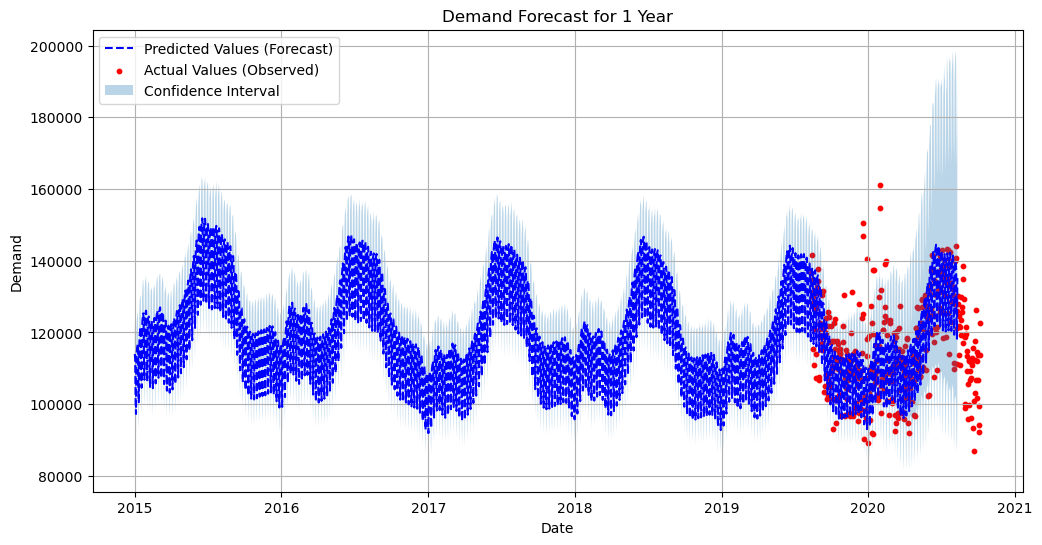

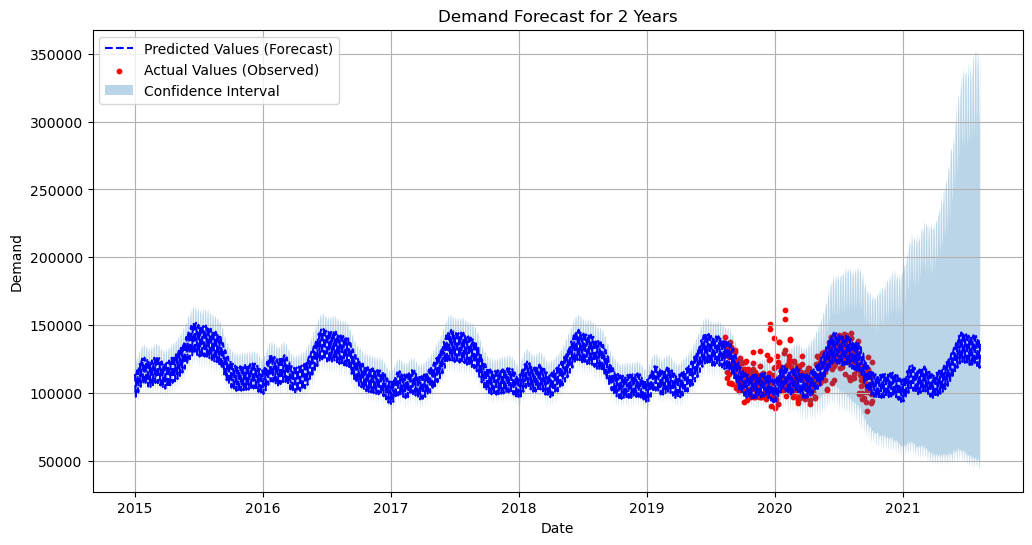

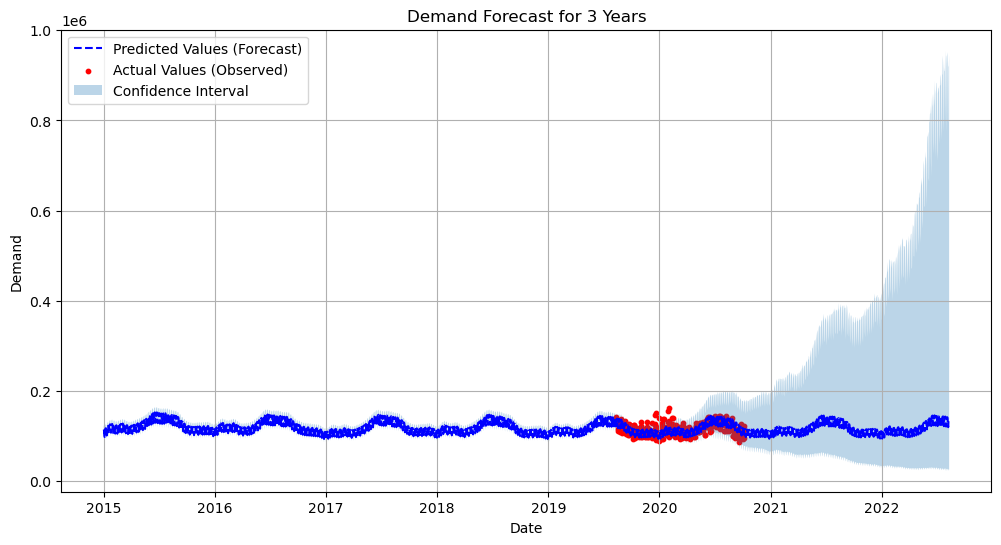

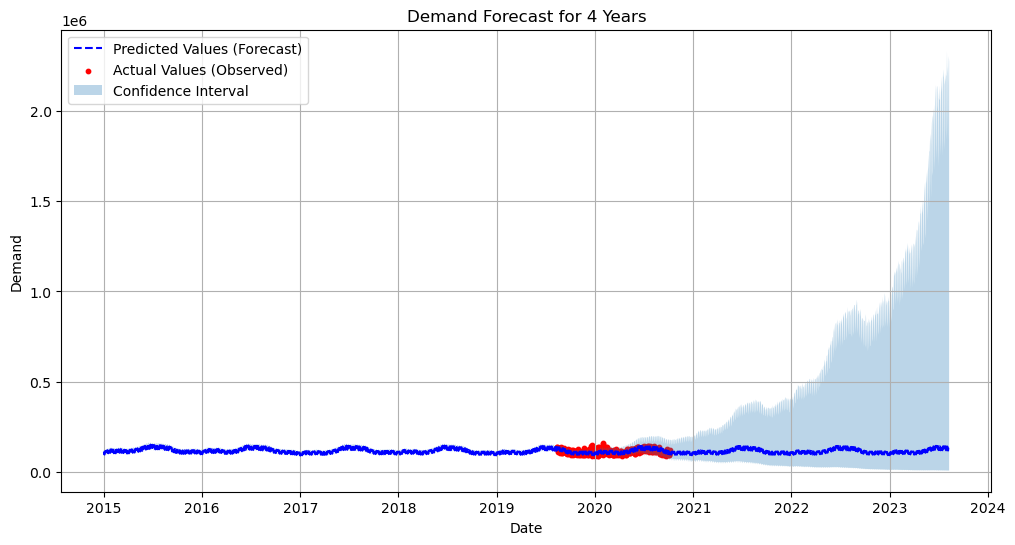

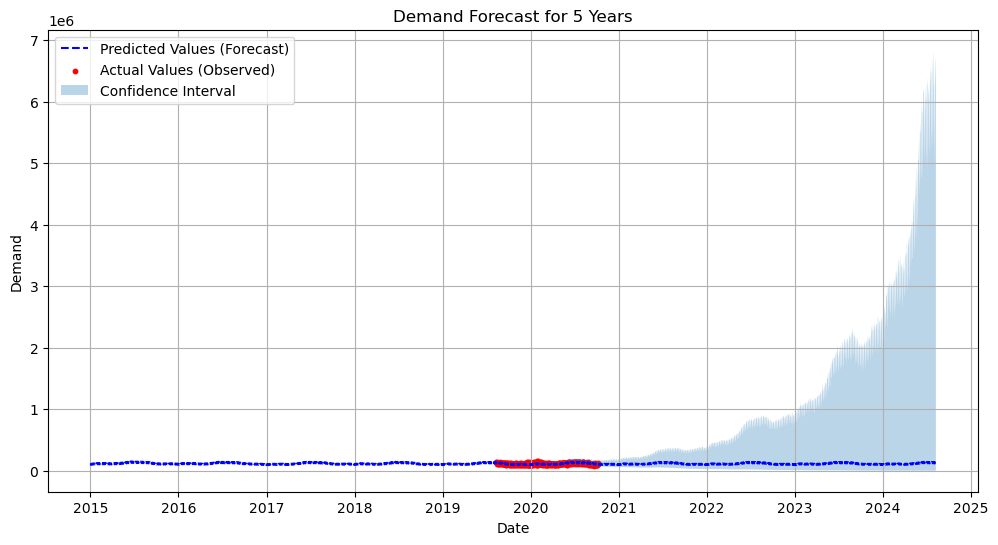

In [22]:
# Forecast for individual years
forecast_periods = {
    '1 Year': 365,
    '2 Years': 365 * 2,
    '3 Years': 365 * 3,
    '4 Years': 365 * 4,
    '5 Years': 365 * 5
}

for label, days in forecast_periods.items():
    future = prophet_model.make_future_dataframe(periods=days, freq='D')
    future['temperature'] = data['temperature'].mean()
    future['is_holiday'] = 0
    future['is_school_day'] = 1
    forecast = prophet_model.predict(future)

    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'], np.expm1(forecast['yhat']), label='Predicted Values (Forecast)', linestyle='dashed', color='blue')
    plt.scatter(test_data['ds'], np.expm1(test_data['y']), color='red', label='Actual Values (Observed)', s=10)
    plt.fill_between(forecast['ds'], np.expm1(forecast['yhat_lower']), np.expm1(forecast['yhat_upper']), alpha=0.3, label='Confidence Interval')
    plt.title(f"Demand Forecast for {label}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
# Evaluate Prophet model
y_true_prophet = np.expm1(test_data['y'].values)
y_pred_prophet = np.expm1(forecast['yhat'][-len(test_data):].values)
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))
performance['Prophet'] = {'MAE': mae_prophet, 'RMSE': rmse_prophet}

In [21]:
# Display performance
print("Model Performance Comparison:")
for model, metrics in performance.items():
    print(f"{model} - MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

Model Performance Comparison:
RandomForest - MAE: 873.2692, RMSE: 2342.5023
DecisionTree - MAE: 979.4936, RMSE: 3008.2660
SVR - MAE: 8783.5261, RMSE: 10953.7641
XGBoost - MAE: 864.8406, RMSE: 2267.6705
Prophet - MAE: 16271.3772, RMSE: 20158.4179
